In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
%matplotlib inline 

In [2]:
class Member:
    def __init__(self, world=None, dna = None, generation=None):
        
        if dna is None:
            self.dna = Member.generate_random_dna(world)
            generation = 0
        else:
            self.dna = dna  
        self.generation = generation
    
    @staticmethod
    def generate_random_dna(world):
        _points = world.points.copy()
        np.random.shuffle(_points)
        base = np.zeros((1,2), dtype='int')
        dna = np.append(base.copy(), _points, axis=0)
        dna = np.append(dna, base.copy(), axis=0)
        #print(f'Generation: len(dna) = {len(dna)}')
        return dna
    
    @property
    def fitness(self):
        def calculate_distance(x1,y1,x2,y2):
            return np.sqrt(x1**2 + x2**2) + np.sqrt(y1**2+y2**2)
            
        score = 0
        for i in range(len(self.dna)-1):
            score += calculate_distance(*self.dna[i], *self.dna[i+1])
        return score
    
    @property
    def mutation_amount(self):
        mutation_amount = int(len(self.dna) /10)
        if mutation_amount > 1: 
            return mutation_amount
        else: 
            return 1
    
    def __eq__(self, other): 
        return self.fitness == other.fitness
    
    def __lt__(self, other):
        return self.fitness < other.fitness
    
    def __repr__(self):
        return f'Generation: {self.generation}, Fitness: {self.fitness}\n'
    
    def crossover(self,other):
        #ordered crossover because dna must be a valid route
        
        num1 = np.random.randint(low=1, high=len(self.dna))
        num2 = np.random.randint(low=1, high=len(self.dna))
        while num1 == num2 or num1-1== num2 or num1+1 == num2:
            num2 = np.random.randint(low=1, high=len(self.dna))

        segment_start = min(num1,num2)
        segment_end = max(num1, num2)
        array1 = self.dna.copy()
        array2 = other.dna.copy()
        #print(f'crossover: len(dna) = {len(self.dna)}')
        #print(f'crossover: len(array1) = {len(array1)}')

        new_dna = np.zeros((len(array1), 2), 'int')
        new_dna[segment_start:segment_end] = array1[segment_start:segment_end].copy()


        bools = [np.all(array2==row,axis=1) for row in array1[segment_start:segment_end]]

        # combine 3 boolean arrays with 'or' logic
        mask = [any(tup) for tup in zip(*bools)]

        # flip the mask
        mask = ~np.array(mask)

        # final index
        out = array2[mask]
        new_dna[new_dna == 0] = out.flatten().copy()

        return new_dna
    
    def mutate(self, p_mutation):
        if np.random.rand() < p_mutation: 
            for i in range(self.mutation_amount):    
                x, y = np.random.randint(low=1, high=len(self.dna)-1, size=(2))
                self.dna[x], self.dna[y] = self.dna[y].copy(), self.dna[x].copy()

    def plot(self, iteration=None):
        fig, ax = plt.subplots(figsize=(7,7))
        plt.scatter(self.dna[:,0], self.dna[:,1])
        #plt.plot(self.dna[:,0], self.dna[:,1])
        points = self.dna.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap='summer', norm=plt.Normalize(0, 10))
        t1 = np.linspace(1, 11, len(self.dna))
        t2 = np.linspace(3, 5, len(self.dna))
        lc.set_array(t1)
        lc.set_linewidth(t2)
        plt.gca().add_collection(lc)
        ax.autoscale_view()
        if iteration == None:
            plt.title(str(self))
        else: 
            plt.title(f'Current best member - Iteration: {iteration}\n{str(self)}')
        plt.show()
        
    def breed(self, other):
        dna = self.crossover(other)
        generation = self.generation + 1
        child = Member(dna=dna, generation=generation)
        child.mutate(p_mutation=0.5)
        return child

In [3]:
class Population:
    
    def __init__(self, num_members=None, world=None, members=None):
        if members == None:
            self.members = [Member(world=world) for i in range(num_members)]
        else: 
            self.members = members
    
    def __add__(self,other):
        self.members.extend(other.members)
    
    def __len__(self):
        return len(self.members)
    
    def __getitem__(self,key):
        return self.members[key]
    
    def __iter(self):
        return self
    
    def __next__(self):
        for member in self.members:
            yield member
            
    def __repr__(self):
        return f'Population with {len(self.members)} members. Avg_fitness: {self.avg_fitness} Avg_generation: {self.avg_generation}'
    
    def sort(self):
        self.members = sorted(self.members)
        
    def next_generation(self, keep_top, breed_top, num_children=None):
        if num_children == None:
            num_children = len(self.members)
        self.members = sorted(self.members)
        keep_index = int(keep_top * len(self.members))
        breed_index = int(breed_top * len(self.members))
        children = []
        children.extend(self.members[:keep_index])
        while len(children) < num_children:
            breeding_pair = np.random.choice(self.members[:breed_index], size=2, replace=False)
            child = breeding_pair[0].breed(breeding_pair[1])
            children.append(child)
        next_generation = Population(members=children)
        return next_generation
    
    def best_member(self):
        return sorted(self.members)[0]
    
    @property
    def avg_fitness(self):
        total_score = 0
        for member in self.members:
            total_score += member.fitness
        
        return total_score / len(self.members)
    
    @property
    def avg_generation(self):
        total = 0
        for member in self.members:
            total += member.generation
        
        return total / len(self.members)

In [4]:
class World:
    def __init__(self, num_points):
        self.points = np.random.choice(np.arange(1,1000), replace=False, size=(num_points,2))
        
    def plot(self):
        fig, ax = plt.subplots(figsize=(7,7))
        plt.title('WORLD')
        plt.scatter(self.points[:,0], self.points[:,1])
        plt.show()

In [5]:
def initialize(num_points, num_members):
    print('---------INITIALIZATION---------')
    world = World(num_points=num_points)
    print(f'Created a world with {num_points} points to travel.')
    population = Population(world=world, num_members=num_members)
    print(f'Created a population with {num_members} members to solve the travelling salesman problem')
    print('-------------------------------------------------------------------------\n')
    return world, population

In [6]:
def main(number_of_iterations):
    # Parameters
    breed_top = 0.4
    keep_top = 0.1
    num_members = 120
    num_points = 30
    # initialize the map and the population
    world, population = initialize(num_points=num_points,num_members=num_members)
    world.plot()
    # for a large number of iterations do:
    for i in range(number_of_iterations):
        # evaluate the fitness of the current population
        # allow members of the population to breed based on their relative score; 
            # i.e., if their score is higher they're more likely to breed
        # keep members of previous generation
            # This allows your solution to be stable
        # add new random members
        population = population.next_generation(keep_top=keep_top, breed_top=breed_top, num_children=num_members)
        population.sort()
    # plot the results
        if i % 100 == 0:
            print(population)
            population.best_member().plot(iteration=i)
            global best
            best = population.best_member()

---------INITIALIZATION---------
Created a world with 30 points to travel.
Created a population with 120 members to solve the travelling salesman problem
-------------------------------------------------------------------------



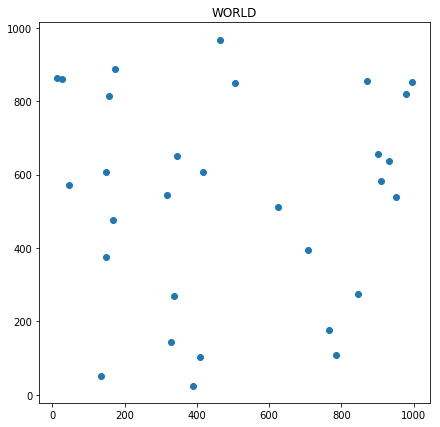

Population with 120 members. Avg_fitness: 47638.42854109326 Avg_generation: 0.9


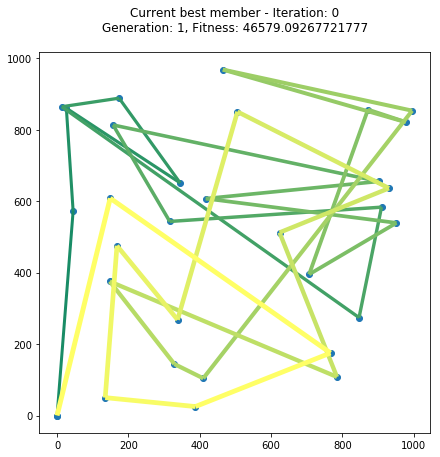

Population with 120 members. Avg_fitness: 45163.870416799204 Avg_generation: 67.40833333333333


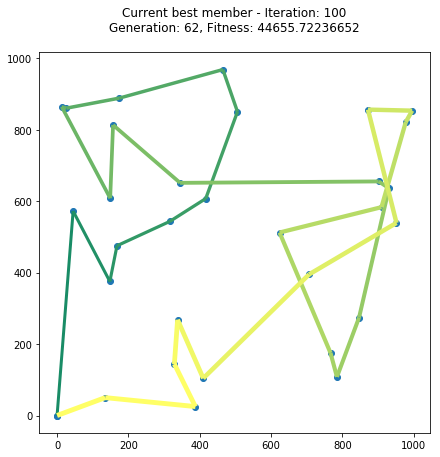

Population with 120 members. Avg_fitness: 45172.725385859645 Avg_generation: 76.64166666666667


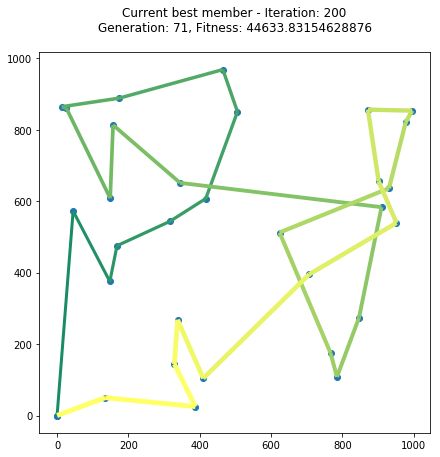

Population with 120 members. Avg_fitness: 45052.9581179983 Avg_generation: 82.66666666666667


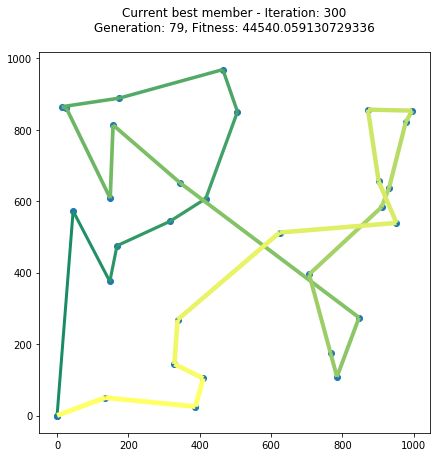

Population with 120 members. Avg_fitness: 44950.74006692699 Avg_generation: 83.39166666666667


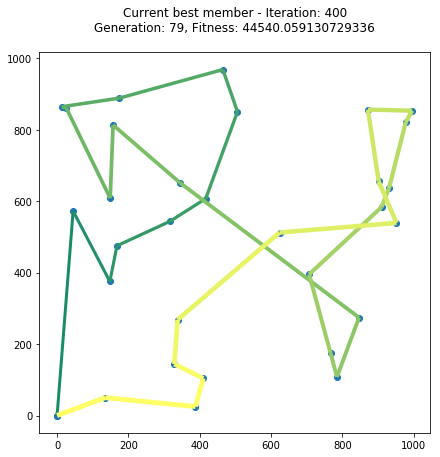

Population with 120 members. Avg_fitness: 45000.034596872785 Avg_generation: 103.70833333333333


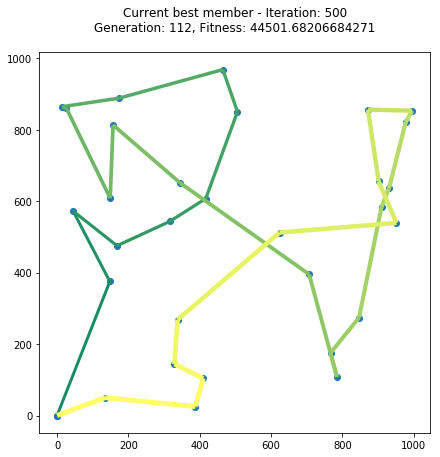

In [7]:
main(501)

In [8]:
best.dna

array([[  0,   0],
       [148, 375],
       [ 45, 572],
       [168, 475],
       [316, 543],
       [417, 607],
       [506, 850],
       [465, 968],
       [174, 888],
       [ 13, 864],
       [ 26, 860],
       [149, 608],
       [157, 813],
       [345, 651],
       [707, 395],
       [785, 108],
       [767, 175],
       [847, 274],
       [910, 583],
       [931, 636],
       [978, 821],
       [996, 853],
       [872, 856],
       [902, 655],
       [952, 539],
       [624, 512],
       [338, 268],
       [329, 144],
       [410, 104],
       [388,  25],
       [135,  50],
       [  0,   0]])